### CNN Feature Based Image Copy Detection With Contextual Hash Embeddings
paper [here](https://www.mdpi.com/2227-7390/8/7/1172/pdf)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import cv2
import numpy as np
import sklearn
from sklearn import preprocessing

In [3]:
#using Pretrained model
import torchvision
from torchvision import models
model = models.alexnet(pretrained = True)
for child in model.children():
    print(child)
    break
#taking only Conv LAyers
model1 = child[:12].cuda()
model1 = model1.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [4]:
#from itertools import chain

def hash_point(pt,arr,r,c):
  if r < 0 or c < 0 or r > 3 or c > 3:
    return 0
  else:
    npt = arr[r][c]
    return 1 if pt < npt else 0

def hash_gen(g,i,j):
  neighborhood = [(i-1,j),(i-1,j-1),(i,j-1),(i+1,j-1),(i+1,j),(i+1,j+1),(i,j+1),(i-1,j+1)]
  pt = g[i][j]
  for nbd in neighborhood:
    yield hash_point(pt,g,*nbd)

def che_gen(g):
   ls1=[]
   for i in range(4):
       for j in range(4):
         ls2=''
         for cow in hash_gen(g,i,j):
           ls2=ls2+str(cow)
         ls1.append(ls2)
   return ls1

In [5]:
#Dividing Image into Slices
def get_blocks(cord,radius,path):
    max_loc = cord
    circle_radius = radius

    #img = cv2.imread(path)
    img = cv2.imread(path,0)
    
    image_array = img.copy()
    mask = np.zeros(image_array.shape, dtype=np.uint8)
    cv2.circle(mask, max_loc, circle_radius, (255, 255, 255), -1, 8, 0)

    result_array = image_array & mask

    # Crop/center result (assuming max_loc is of the form (x, y))
    result_array1 = result_array[max(0,max_loc[1] - circle_radius):max(0,max_loc[1] + circle_radius),
                             max(0,max_loc[0] - circle_radius):max(0,max_loc[0] + circle_radius)]

    #convert to log polar space
    log_polar = cv2.logPolar(result_array1,(radius,radius),circle_radius,1)

    
    #divide into blocks
    log_polar_gray  = log_polar
    M = int(log_polar_gray.shape[0]/4)
    N = int(log_polar_gray.shape[1]/4)

    slices = []
    for j in range(4):
        for i in range(4):
            if j!=3 and i!=3: #center
                slices.append(img[j*N:j*N+N,i*M:i*M+M])
            if j!=3 and i == 3: #top right corner
                slices.append(img[j*N:j*N+N,i*M:])
            if j == 3 and i!=3: #bottom down
                slices.append(img[j*N:,i*M:i*M+M])
            if j==3 and i ==3: #bottom corner
                slices.append(img[j*N:,i*M:])
    
    return slices
    

In [6]:
#for getting keypoints and radius
def get_coordinates_and_radius(keypoints_orb):
    keys = []
    for i in keypoints_orb:
        cord = [int(i) for i in i.pt]
        rad = int(i.size/2)
        keys.append([tuple(cord),rad])
    return keys

### CFM_LocalCNNFeatures_Hashembedding

In [8]:
'''
import numpy
files_path="/content/gdrive/My Drive/pixy_final_repo/5/"
val =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order
images = [str(i)+".jpg" for i in val] #getting files in order


total_images_features = []
total_images_hash_values = []

for idx,i in enumerate(images):
    #reading image
    img = cv2.imread(files_path+i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
    
    #image to alexnet to get CFMs
    data_transform = transforms.ToTensor()
    img1 = data_transform(img)
    img2 = img1.unsqueeze(0)
    op = model1(img2.cuda())
    output = np.array(op.detach().cpu().numpy()[0]) #1,256,height,width
    
    #calculating image and cfm areas for ratio
    img_area = img.shape[0]*img.shape[1]
    cfm_area = output.shape[1]*output.shape[2] 
    area_ratio = cfm_area/img_area
    
    #passing image to ORB
    orb = cv2.ORB_create(nfeatures=1500)
    #keypoints_orb, descriptors = orb.detectAndCompute(img, None)
    keypoints_orb= orb.detect(img, None)
    keypoints = get_coordinates_and_radius(keypoints_orb)
  
    
    
    #Scaling CFM radius and coordinates
    cfm_radius = []
    cfm_coo = []
    for key in keypoints:
        cfm_radius.append(np.float32(area_ratio*key[1]))
        cfm_x = (output.shape[1]*key[0][0])/img.shape[0]
        cfm_y = (output.shape[2]*key[0][1])/img.shape[1]
        cfm_coo.append((np.float32(cfm_x),np.float32(cfm_y)))

    #Finding normalized radius from Minimum of 1 to B value
    val = [key[1] for key in keypoints]  
    x = np.array(cfm_radius)
    b = (max(val)-min(val))/(min(val))
    a = 1
    normalized_radius=(b-a)*((x-x.min())/(x.max()-x.min()))+a
    
    #For finding local CNN features(mapping keypoints to CFM)
    all_keypoint_features = []
    output = np.array(op.detach().cpu().numpy()[0])
    for cord,rad in zip(cfm_coo,normalized_radius):
        feature_map = []
        for fmap in range(len(output)):
            op = np.sum(output[fmap][int(cord[0]):int(cord[0])+int(rad),int(cord[1]):int(cord[1])+int(rad)])
            feature_map.append(op)
        op1 = np.array(feature_map).reshape(1,256)
        norm_final = sklearn.preprocessing.normalize(op1, norm='l2', axis=1, copy=True, return_norm=False)
        all_keypoint_features.append(norm_final)    
    
    #stacking all keypoints(ex:400) of a single image
    keypoint_feat = all_keypoint_features[0]
    for keypoint in all_keypoint_features[1:]:
        keypoint_feat = np.vstack((keypoint_feat,keypoint))

    print(keypoint_feat.shape)#(483,256)(500,256) 256 columns fixed

    total_images_features.append(keypoint_feat)
    
    #multiplying radius with Alpha 3.2
    expanded_radius = []
    for key,radius in keypoints:
        expand_r = int(int(radius/2)*3.2)
        expanded_radius.append(expand_r)
    
    cords = []
    for cord,radius in keypoints:
        cords.append(cord)
    
    #get Hash Values
    all_hash_values = []
    for cord,ex_radius in zip(cords,expanded_radius):
        slices = get_blocks(cord,radius,files_path+i)
        grey_intensities = np.array([np.mean(i) for i in slices]).reshape(4,4)
        hash_val = che_gen(grey_intensities)
        all_hash_values.append(hash_val)
    
    total_images_hash_values.append(all_hash_values)

    if idx==2 or idx==10 or idx==20 or idx==40 or idx==80 or idx==120 or idx==157:
       print(idx)
       numpy.savez('/content/gdrive/My Drive/pixy_final_repo/' + str(idx) + '.npz', a=total_images_hash_values, b=total_images_features)   
'''

'\nimport numpy\nfiles_path="/content/gdrive/My Drive/pixy_final_repo/5/"\nval =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order\nimages = [str(i)+".jpg" for i in val] #getting files in order\n\n\ntotal_images_features = []\ntotal_images_hash_values = []\n\nfor idx,i in enumerate(images):\n    #reading image\n    img = cv2.imread(files_path+i)\n    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\n  \n    \n    #image to alexnet to get CFMs\n    data_transform = transforms.ToTensor()\n    img1 = data_transform(img)\n    img2 = img1.unsqueeze(0)\n    op = model1(img2.cuda())\n    output = np.array(op.detach().cpu().numpy()[0]) #1,256,height,width\n    \n    #calculating image and cfm areas for ratio\n    img_area = img.shape[0]*img.shape[1]\n    cfm_area = output.shape[1]*output.shape[2] \n    area_ratio = cfm_area/img_area\n    \n    #passing image to ORB\n    orb = cv2.ORB_create(nfeatures=1500)\n    #keypoints_orb, descriptors = orb.detectA

In [ ]:
'''
import numpy
numpy.savez('/content/gdrive/My Drive/pixy_final_repo/final_query_157', a=total_images_hash_values, b=total_images_features)
'''

In [ ]:
'''
import numpy
vet = numpy.load('gdrive/My Drive/copy_detection/scaled_vector_data.npz', allow_pickle= True)
total_images_hash_values1 = vet['a']
total_images_features1 = vet['b']
'''

### 3. Local_CNN_VBOW

In [ ]:
'''
import scipy
import random

random.seed(101)

from scipy.cluster.vq import kmeans,vq #vq stands for vector quantization
k= 100 #maximum clusters can be 50
                                           

voc1,variance=kmeans(img_feat,k)        #voc decides no of clusters to be formed, based on distace
                                           # 50 is no of iterations

#clustering all the keypoints of all images
database_words = []
im_features=np.zeros((len(os.listdir(files_path)),k),"float32")
for i in range(len(os.listdir(files_path))):
    words1,distance=vq(total_images_features[i],voc1) #vector quantization
    database_words.append(words1)
    for w in words1:
        im_features[i][w]+=1
'''

In [ ]:
#import numpy
#numpy.savez('/content/gdrive/My Drive/Pixy_project/copy/3_images_information.npz', a=total_images_hash_values, b=total_images_features, c = voc1, d = im_features, e = database_words)

In [9]:
import numpy
vet = numpy.load('/content/gdrive/My Drive/copy_detection/Shubham_28oct/final_db_with_centroids.npz', allow_pickle= True)
total_images_hash_values = vet['a']
total_images_features = vet['b']
voc1 = vet['c']
im_features = vet['d']
database_words = vet['e']


### querry_image

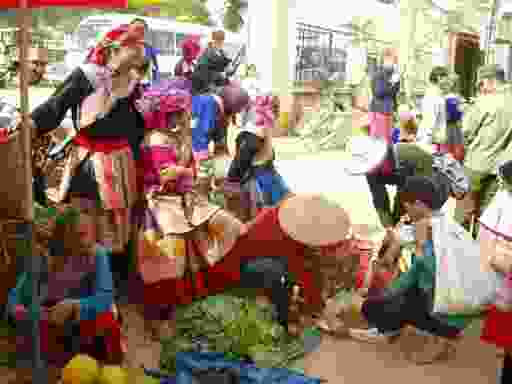

In [12]:
import os
#lets take a sample image
path = "/content/gdrive/My Drive/copy_detection/Pixy_project/5/200200.jpg"
from PIL import Image
Image.open(path)

In [13]:
from torchvision import transforms
file = Image.open(path)

data_transform = transforms.ToTensor()
img1 = data_transform(file)
op = model1(img1.unsqueeze(0).cuda())

In [14]:
output = np.array(op.detach().cpu().numpy()[0]) #1,256,height,width

In [15]:
output.shape #cfms generated

(256, 23, 31)

In [16]:
import cv2
img = cv2.imread(path)

In [17]:
orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)

keypoints = get_coordinates_and_radius(keypoints_orb)

In [23]:
#calculating image and cfm areas for ratio
img_area = img.shape[0]*img.shape[1]
cfm_area = output.shape[1]*output.shape[2] 
area_ratio = cfm_area/img_area

In [24]:
#Scaling CFM radius and coordinates
cfm_radius = []
cfm_coo = []
for key in keypoints:
    cfm_radius.append(np.float32(area_ratio*key[1]))

    cfm_x = (output.shape[1]*key[0][0])/img.shape[0]
    cfm_y = (output.shape[2]*key[0][1])/img.shape[1]
    cfm_coo.append((np.float32(cfm_x),np.float32(cfm_y)))

#Finding normalized radius from Minimum of 1 to B value
val = [key[1] for key in keypoints]    
x = np.array(cfm_radius)
b = (max(val)-min(val))/(min(val))
#     print(b)
a = 1
normalized_radius=(b-a)*((x-x.min())/(x.max()-x.min()))+a

In [25]:
all_keypoint_features = []
output = np.array(op.detach().cpu().numpy()[0])
for cord,rad in zip(cfm_coo,normalized_radius):
    feature_map = []
    for fmap in range(len(output)):
        op = np.sum(output[fmap][int(cord[0]):int(cord[0])+int(rad),int(cord[1]):int(cord[1])+int(rad)])
        feature_map.append(op)
    op1 = np.array(feature_map).reshape(1,256)
    norm_final = sklearn.preprocessing.normalize(op1, norm='l2', axis=1, copy=True, return_norm=False)
    all_keypoint_features.append(norm_final)    
#     print(all_keypoint_features[0].shape)#(1,256)


In [26]:
keypoint_feat = all_keypoint_features[0]
for keypoint in all_keypoint_features[1:]:
    keypoint_feat = np.vstack((keypoint_feat,keypoint))

In [27]:
keypoint_feat.shape #324 keypoints only for a test image

(1500, 256)

### we got 256 local CNN features for al the 430 Keypoints. Now Generating CHE for all 430 keypoints

In [28]:
img2 = cv2.drawKeypoints(img, keypoints_orb, None)

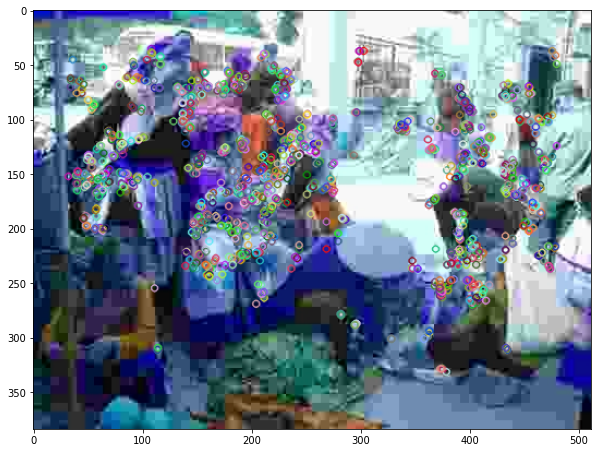

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,12))
plt.imshow(img2)
plt.show()

In [30]:
expanded_radius = []
for key,radius in keypoints:
    expand_r = int(int(radius/2)*3.2)
    expanded_radius.append(expand_r)

In [31]:
cords = []
for cord,radius in keypoints:
    cords.append(cord)

In [32]:
path = "/content/gdrive/My Drive/pixy_final_repo/5/200200.jpg"

all_hash_values = []
for cord,ex_radius in zip(cords,expanded_radius):
    slices = get_blocks(cord,radius,path)
#     print(len(slices))
    grey_intensities = np.array([np.mean(i) for i in slices]).reshape(4,4)
    hash_val = che_gen(grey_intensities)
    all_hash_values.append(hash_val)

AttributeError: ignored

In [33]:
len(all_hash_values) #324 hash points for our querry image

0

In [34]:
print(keypoint_feat)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.12314405 0.09643687 0.         ... 0.         0.         0.        ]
 [0.03588741 0.         0.10066377 ... 0.         0.         0.        ]
 ...
 [0.00151988 0.1790185  0.         ... 0.05030892 0.01364168 0.        ]
 [0.         0.01051377 0.         ... 0.00658307 0.         0.        ]
 [0.         0.17069656 0.         ... 0.         0.         0.        ]]


In [35]:
'''
import numpy
numpy.savez('/content/gdrive/My Drive/copy_detection/singlefile.npz', a=all_hash_values, b=keypoint_feat)
'''

"\nimport numpy\nnumpy.savez('/content/gdrive/My Drive/copy_detection/singlefile.npz', a=all_hash_values, b=keypoint_feat)\n"

In [36]:
# import scipy
# import random
# random.seed(101)

from scipy.cluster.vq import kmeans,vq #vq stands for vector quantization
k= 100
# voc,variance=kmeans(keypoint_feat,k,50) #all keypoint features of all images

q_features=np.zeros((1,k),"float32")    
words,distance=vq(keypoint_feat,voc1) #all keypoint features of single image
for w in words:
    q_features[0][w]+=1

In [37]:
import sys
import numpy 
numpy.set_printoptions(threshold=sys.maxsize)

### Inverted index Creation 

In [38]:
# #generating filepath:im_features in dictionary

files_path="/content/gdrive/My Drive/copy_detection/Pixy_project/copydays_original/"
val =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order
images = [str(i)+".jpg" for i in val] #getting files in order

image_vocab = {} #filepath,vocab
for file_name,im_feature in zip(images,im_features):
    image_vocab[file_name] = list(im_feature)

In [39]:
from collections import defaultdict

inv_indx = defaultdict(list) #defaultdict(list, {})

for imgidx,vocab in image_vocab.items():
    for idx,count in enumerate(vocab):
        if int(count) > 0:
            inv_indx[idx].append(imgidx)

In [40]:
from collections import defaultdict
inverted_indx = defaultdict(list) 


for image_id,feature,kp in zip(list(range(len(images))),im_features,database_words): #101.jpg, im_feature,430kp
    for indx,count in enumerate(feature): #for every feature in im_features
        if int(count)>0: #if fequency value is >0
            # no = int(image_id.split(".")[0]) # image no
            hashes = [{ind:total_images_hash_values[image_id][ind]}  for ind,j in enumerate(kp) if j == indx]
            inverted_indx[indx].append([image_id,hashes])

#### inverted_index for querry image

In [41]:
#for querry image
#generating filepath:im_features in dictionary

q_image = ['200200.jpg']
q_image_vocab = {} #filepath,vocab
for file_name,q_feature in zip(q_image,q_features):
    q_image_vocab[file_name] = list(q_feature)


In [42]:
from collections import defaultdict

q_inv_indx = defaultdict(list) #defaultdict(list, {})

for imgidx,vocab in q_image_vocab.items():
    for idx,count in enumerate(vocab):
        if int(count) > 0:
            q_inv_indx[idx].append(imgidx)

In [51]:
from collections import defaultdict
q_inverted_indx = defaultdict(list) 
for indx,count in enumerate(q_features[0]): #for every feature in im_features
    if int(count)>0: #if fequency value is >0
        no = int(q_image[0].split(".")[0]) # image no
        hashes = [{ind:all_hash_values[ind]}  for ind,j in enumerate(words) if j == indx]
        q_inverted_indx[indx].append([q_image[0],hashes])

IndexError: ignored

In [44]:
import math
dict1={}
for i in range(0,len(im_features)):
  apple=im_features[i]
  for index,value in enumerate(apple):
    if value > 0:
      if index in dict1:
        dict1[index]=dict1[index] +1
      else:
        dict1[index]=1
for key,value in dict1.items():
  IDF= math.log(len(im_features) / value)
  dict1[key]=IDF
idf_dict=dict1

In [45]:
inverted_indx.keys()

dict_keys([13, 14, 57, 1, 4, 6, 10, 11, 12, 15, 16, 17, 19, 20, 21, 24, 25, 26, 29, 34, 38, 39, 40, 41, 42, 43, 52, 54, 55, 58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 71, 76, 79, 80, 81, 82, 0, 2, 3, 5, 7, 8, 18, 22, 27, 28, 30, 31, 33, 35, 36, 37, 46, 48, 50, 51, 56, 65, 69, 73, 75, 23, 45, 74, 77, 9, 32, 47, 49, 53, 61, 78, 44, 72])

In [46]:
inverted_indx[1][0][0] #cluster1, first images out of 6 images,imagename
inverted_indx[1][0][1] #cluster1, first images out of 6 images, kp and hash
inverted_indx[1][0][1][0].values() #first hash values

dict_values([['00000000', '00100010', '00000110', '00000000', '10000011', '11000001', '11100111', '10000000', '10000011', '11000001', '11100011', '10000000', '10000011', '11000011', '11000001', '11100000']])

In [47]:
from typing import List
def distance_hash_sequence(q_hash_sequence:List[str],d_hash_sequence:List[str])->float:
    M = 4
    N = 4
    distance = 0
    #calculating the distance
    for index in range(0,len(q_hash_sequence)):
        for q_hash_sequence_bit,d_hash_sequence_bit in zip(list(q_hash_sequence[index]),list(d_hash_sequence[index])):
            distance+=abs(int(q_hash_sequence_bit)-int(d_hash_sequence_bit))/(M*N*8)
    return distance

In [48]:
dist_t = 0.35

final_res = {}
for i in q_inverted_indx.keys():                     #querry clusters
    for j in inverted_indx.keys():                   #database clusters
        if i==j:
            images = len(inverted_indx[i])#6 images to compare
            img_count = {}
            for image in range(images):             #in each image
                mini = min(len(inverted_indx[i][image][1]),len(q_inverted_indx[i][0][1])) #which one has less len
                for hs in range(mini):
                    a = list(q_inverted_indx[i][0][1][hs].values())[0]
                    b = list(inverted_indx[i][image][1][hs].values())[0]
                    dist = distance_hash_sequence(a,b)
                    if dist < dist_t:
                        if inverted_indx[i][image][0] not in img_count:
                            img_count[inverted_indx[i][image][0]]=0
                        if inverted_indx[i][image][0] in img_count:
                            img_count[inverted_indx[i][image][0]]+=1
    final_res[i]=img_count

In [49]:
final_res

{}

In [50]:
q_inverted_indx.keys()

dict_keys([])

In [ ]:
for vbw  in q_inverted_indx.keys():
    for val,key in final_res[vbw].items():
        print(vbw,":",val,key*idf_dict[vbw])

0 : 1 6.630012520601284
0 : 2 180.11534014300153
0 : 4 62.985118945712195
0 : 9 1.1050020867668806
0 : 16 145.86027545322824
0 : 20 79.5601502472154
0 : 21 8.840016694135045
0 : 26 26.520050082405135
0 : 27 4.420008347067522
0 : 29 2.210004173533761
0 : 30 175.695331795934
0 : 33 62.985118945712195
0 : 35 13.260025041202567
0 : 36 32.04506051623954
0 : 40 116.02521911052247
0 : 46 1.1050020867668806
0 : 48 27.625052169172015
0 : 51 24.310045908871373
0 : 55 18.78503547503697
0 : 56 11.050020867668806
0 : 58 2.210004173533761
0 : 62 57.46010851187779
0 : 63 187.85035475036972
0 : 70 5.525010433834403
0 : 76 13.260025041202567
0 : 78 2.210004173533761
0 : 80 1.1050020867668806
0 : 85 26.520050082405135
0 : 95 7.735014607368164
0 : 114 6.630012520601284
0 : 115 69.61513146631347
0 : 120 59.67011268541155
0 : 136 117.13022119728934
0 : 139 39.7800751236077
0 : 142 82.87515650751604
0 : 145 18.78503547503697
0 : 150 56.35510642511091
0 : 151 36.46506886330706
0 : 154 53.04010016481027
1 : 1

In [ ]:
file = {}
for vbw  in q_inverted_indx.keys():
    for val,key in final_res[vbw].items():
#         print(val,key*IDF_database[vbw][0])
        if val not in file:
            file[val] = key*idf_dict[vbw]
        if val in file:
            file[val]+= key*idf_dict[vbw]
        

In [ ]:
# Final Answer

In [ ]:
sorted(file.items(), key=lambda item: item[1],  reverse=True)

[(2, 1190.7132491000862),
 (63, 791.3882647818956),
 (16, 692.4335569935473),
 (30, 690.2512746510029),
 (142, 538.6559171004969),
 (139, 492.186886897391),
 (4, 453.1140076555982),
 (150, 448.3220136208249),
 (20, 393.4424684818004),
 (40, 382.8008882109544),
 (49, 366.64738285900626),
 (136, 341.2781824034121),
 (33, 307.7849880405661),
 (29, 292.5083100148883),
 (104, 289.7805842435986),
 (151, 286.1326915602068),
 (56, 282.8098493060731),
 (51, 276.7459539946785),
 (55, 272.92551858000246),
 (120, 253.88028052411502),
 (46, 250.8938956113021),
 (111, 238.1685683324775),
 (154, 232.15528856856926),
 (148, 228.60052119388817),
 (152, 219.43543965459733),
 (61, 212.73097615634993),
 (62, 206.16428824437503),
 (110, 201.4102136112252),
 (145, 190.81296604834068),
 (76, 190.2017165614135),
 (32, 189.2442220337187),
 (96, 183.34613078813896),
 (85, 180.1847667094377),
 (27, 175.48582672091288),
 (53, 173.58143409004524),
 (92, 172.54651033805015),
 (114, 172.34993124810416),
 (41, 171.36

### Image, weight

In [ ]:
files_path="/content/gdrive/My Drive/pixy_final_repo/5/"
val =sorted([int(i.split(".")[0]) for i in os.listdir(files_path)]) #os.listdir wont give you file order
images = [str(i)+".jpg" for i in val] #getting files in order

In [ ]:
for i,j in enumerate(images):
  print(i,j)

0 200000.jpg
1 200100.jpg
2 200200.jpg
3 200300.jpg
4 200400.jpg
5 200500.jpg
6 200600.jpg
7 200700.jpg
8 200800.jpg
9 200900.jpg
10 201000.jpg
11 201100.jpg
12 201200.jpg
13 201300.jpg
14 201400.jpg
15 201500.jpg
16 201600.jpg
17 201700.jpg
18 201800.jpg
19 201900.jpg
20 202000.jpg
21 202100.jpg
22 202200.jpg
23 202300.jpg
24 202400.jpg
25 202500.jpg
26 202600.jpg
27 202700.jpg
28 202800.jpg
29 202900.jpg
30 203000.jpg
31 203100.jpg
32 203200.jpg
33 203300.jpg
34 203400.jpg
35 203500.jpg
36 203600.jpg
37 203700.jpg
38 203800.jpg
39 203900.jpg
40 204000.jpg
41 204100.jpg
42 204200.jpg
43 204300.jpg
44 204400.jpg
45 204500.jpg
46 204600.jpg
47 204700.jpg
48 204800.jpg
49 204900.jpg
50 205000.jpg
51 205100.jpg
52 205200.jpg
53 205300.jpg
54 205400.jpg
55 205500.jpg
56 205600.jpg
57 205700.jpg
58 205800.jpg
59 205900.jpg
60 206000.jpg
61 206100.jpg
62 206200.jpg
63 206300.jpg
64 206400.jpg
65 206500.jpg
66 206600.jpg
67 206700.jpg
68 206800.jpg
69 206900.jpg
70 207000.jpg
71 207100.jpg
72

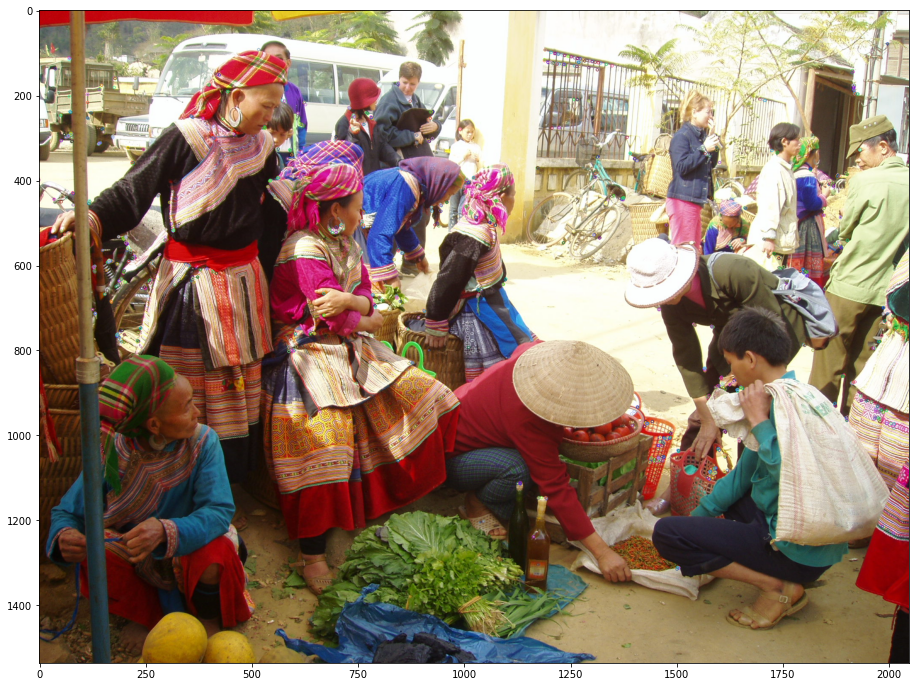

In [ ]:
import os
#lets take a sample image
path = "/content/gdrive/My Drive/pixy_final_repo/copydays_original/200200.jpg"

import cv2
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)

keypoints = get_coordinates_and_radius(keypoints_orb)
img2 = cv2.drawKeypoints(img, keypoints_orb, None)
import matplotlib.pyplot as plt
plt.figure(figsize = (40,12))
plt.imshow(img2)
plt.show()

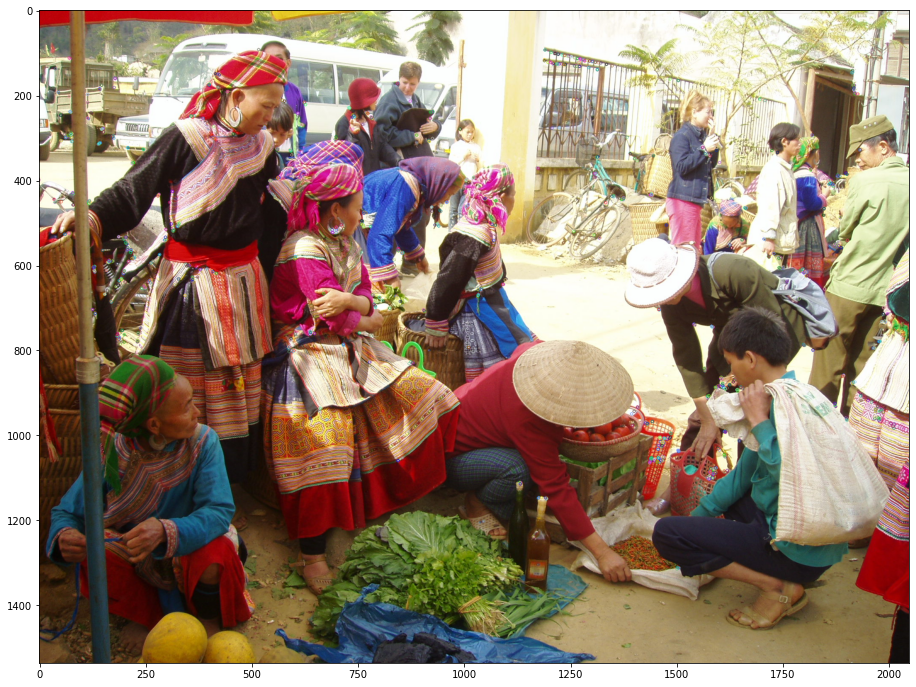

In [ ]:
import os
#lets take a sample image
path = "/content/gdrive/My Drive/pixy_final_repo/copydays_original/200200.jpg"

import cv2
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)

keypoints = get_coordinates_and_radius(keypoints_orb)
img2 = cv2.drawKeypoints(img, keypoints_orb, None)
import matplotlib.pyplot as plt
plt.figure(figsize = (40,12))
plt.imshow(img2)
plt.show()